## My model performance on the Chakraborty data set was very high while webis was very low

Here, I would like to delve a little bit deeper into the data differences between my datasets. In particular, I would like to filter the Webis data set for any headline that is near the decision boundary. That is, 5 people voted and they took the average of the rating on a likert scale. That means that some of headlines were near the decision boundar. I would like to firstly examine those headlines and then move on to may removing them from the analysis in order to improve my model performance. 

I see this as an opportunity to tune the the model to the real world case. I only want to identify the most sensationalist click bait. My model has a high f1, but I am willing to sacrifice some recall (increase false negatives) if it means that I am only classifying the most aggregious examples. 

In [1]:
# import libraries 
import json
import numpy as np
import pandas as pd
import os

%matplotlib inline

# Paths to the third dataset, (webis 2017)
dataset3_json = './src/data/dataset3/clickbait17-validation-170630/instances.jsonl'
dataset3_json_labels = './src/data/dataset3/clickbait17-validation-170630/truth.jsonl'

In [2]:
# Load dataset3
dataset3 = []
with open(dataset3_json) as f:
    for line in f:
        dataset3.append(json.loads(line))
        
dataset3_labels = []
with open(dataset3_json_labels) as f:
    for line in f:
        dataset3_labels.append(json.loads(line))

Each label is a json with the results of all of the votes cast by the amazon mechanical turks. They took the mean to be the ground truth. If the mean was above 0.5, I assumed that it mean that it was click bait, if it was lower, they took it to mean that the headline was not clickbait. Here I will test that assumption:

In [5]:
dataset3_labels[1]

{'truthJudgments': [0.3333333333, 0.0, 0.3333333333, 0.0, 0.0],
 'truthMean': 0.13333333332,
 'id': '858462320779026433',
 'truthClass': 'no-clickbait',
 'truthMedian': 0.0,
 'truthMode': 0.0}

In [37]:
def examine_truth(json_list):
    tuples_ = []
    for json_ in json_list:
        id_ = json_['id']
        truthJudgments = json_['truthJudgments']
        truth_mean = json_['truthMean']
        truthClass = json_['truthClass']
        tuples_.append((id_, truthJudgments, truth_mean, truthClass))
    return pd.DataFrame(tuples_, columns = ['id', 'judgements', 'mean_', 'class_'])

webis_df = examine_truth(dataset3_labels)

In [38]:
webis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19538 entries, 0 to 19537
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          19538 non-null  object 
 1   judgements  19538 non-null  object 
 2   mean_       19538 non-null  float64
 3   class_      19538 non-null  object 
dtypes: float64(1), object(3)
memory usage: 610.7+ KB


In [39]:
webis_df.head()

,id,judgements,mean_,class_
0,858464162594172928,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait
1,858462320779026433,"[0.3333333333, 0.0, 0.3333333333, 0.0, 0.0]",0.133333,no-clickbait
2,858460992073863168,"[0.3333333333, 0.6666666666, 1.0, 0.0, 0.0]",0.400000,no-clickbait
3,858459539296980995,"[0.0, 0.6666666666, 0.0, 0.3333333333, 0.33333...",0.266667,no-clickbait
4,858455355948384257,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait


In [40]:
webis_df.groupby(['class_']).mean_.mean()

class_
clickbait       0.689155
no-clickbait    0.207051
Name: mean_, dtype: float64

In [43]:
webis_df[webis_df.class_ == 'clickbait'].mean_.describe()

count    4761.000000
mean        0.689155
std         0.146736
min         0.400000
25%         0.600000
50%         0.666667
75%         0.800000
max         1.000000
Name: mean_, dtype: float64

In [48]:
webis_df[(webis_df.class_ == 'clickbait') & (webis_df.mean_ < 0.5)].head(2)

,id,judgements,mean_,class_
88,858254593481990145,"[0.6666666666, 0.6666666666, 0.6666666666, 0.3...",0.466667,clickbait
127,858122416312209408,"[0.6666666666, 0.6666666666, 0.0, 0.0, 0.66666...",0.400000,clickbait


Ok, so they definitely did not take the mean between all of the voters, they took the median or the mode and ued that as ground truth. Let's look at the variance in the clickbait votes versus the variance in the non-clickbait votes. My hypothesis is that one class will have a higher variance than the other. I then want to look ath the highest variance examples from each class and make a judgement call on whether or not to exclude them

In [57]:
# Test if I can simply use numpy to pull out the std axis 1 
def get_std(list_):
    return np.std(list_)


webis_df['std_'] = webis_df.judgements.apply(get_std)
webis_df['std_'].describe()

count    19538.000000
mean         0.241240
std          0.122331
min          0.000000
25%          0.163299
50%          0.266667
75%          0.339935
max          0.489898
Name: std_, dtype: float64

That is a lot of variation in the std! considering the scale is only 0-1, the findding that some of the headlines had a std of 0.5 is surprising. Now, I will import the the text files and join them on to this data, sort values by std and visually inspect the headlines to see how I personally would classify them. 

In [66]:
dataset3[1].keys()

dict_keys(['postMedia', 'postText', 'id', 'targetCaptions', 'targetParagraphs', 'targetTitle', 'postTimestamp', 'targetKeywords', 'targetDescription'])

In [69]:
def get_text(json_list):
    tuples_ = []
    for json_ in json_list:
        id_ = json_['id']
        title = json_['targetTitle']
        tuples_.append((id_, title))
    return pd.DataFrame(tuples_, columns = ['id', 'title'])



df = get_text(dataset3)


fulldf = df.merge(webis_df)

In [100]:
fulldf

,id,title,judgements,mean_,class_,std_
0,858462320779026433,‘Inexcusable’ failures in UK’s response to mod...,"[0.3333333333, 0.0, 0.3333333333, 0.0, 0.0]",0.133333,no-clickbait,0.163299
1,858421020331560960,Donald Trump Appoints Pro-Life Advocate as Ass...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait,0.000000
2,858368123753435136,The ‘forgotten’ Trump roast: Relive his brutal...,"[0.3333333333, 1.0, 0.3333333333, 0.0, 0.66666...",0.466667,no-clickbait,0.339935
3,858323428260139008,"Meet The Happiest Dog In The World, Maru The H...","[1.0, 0.6666666666, 1.0, 1.0, 1.0]",0.933333,clickbait,0.133333
4,858283602626347008,Tokyo's subway is shut down amid fears over an...,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait,0.000000
...,...,...,...,...,...,...
19533,804250183642976256,"NBC News Video See Brazil Soccer Team, Pilot’s...","[0.3333333333, 0.0, 1.0, 0.6666666666, 0.0]",0.400000,no-clickbait,0.388730
19534,804156272086020096,Politico Scoop: Eric Trump Killed Two Deer,"[1.0, 1.0, 1.0, 1.0, 0.0]",0.800000,clickbait,0.400000
19535,804149798651588608,Frenchs Forest high school may relocate to mak...,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait,0.000000
19536,804134698729385984,Los Angeles Rams Jeff Fisher May Think Danny W...,"[0.0, 0.0, 0.0, 0.0, 0.6666666666]",0.133333,no-clickbait,0.266667


In [113]:
fulldf[fulldf.class_ == 'no-clickbait'].sort_values('std_', ascending= False).title.iloc[3]

'There was a big difference in the way Trump signed his new travel ban'

## This analysis didn't yeild any additional information apart from the fact that this dataset is labelled poorly.

It seems like this data set included a lot of extra information about the post, media, descriptions and key words. but from the actual title alone, it is really difficult to determine which title are click and which are not. 

Let's a look at the mean vote between classes

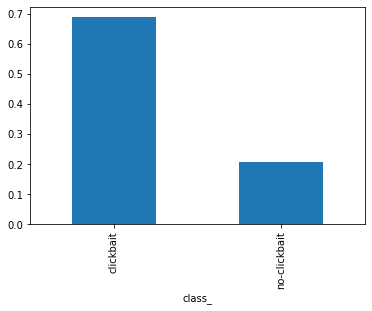

In [116]:
fulldf.groupby(['class_']).mean_.mean().plot(kind='bar');

There is definitely a class difference here. I will filter both classes out such that no 

In [129]:
fulldf[(fulldf.class_ == 'no-clickbait') & (fulldf.mean_ < 0.3)].mean_.mean()

0.13660456249240568

In [130]:
fulldf[(fulldf.class_ == 'clickbait')].mean_.describe()

count    4761.000000
mean        0.689155
std         0.146736
min         0.400000
25%         0.600000
50%         0.666667
75%         0.800000
max         1.000000
Name: mean_, dtype: float64

Here, we see that only 2000 of the total click bait headlines have a mean clickbaityness of above 0.6. This indicates that there is a further confounder in the labelling of the date whereby th voters were confused about the 

In [125]:
fulldf[(fulldf.class_ == 'clickbait')]

,id,title,judgements,mean_,class_,std_
1,858421020331560960,Donald Trump Appoints Pro-Life Advocate as Ass...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait,0.000000
3,858323428260139008,"Meet The Happiest Dog In The World, Maru The H...","[1.0, 0.6666666666, 1.0, 1.0, 1.0]",0.933333,clickbait,0.133333
10,858137811039465472,The top 10 best selling comic books of all tim...,"[0.6666666666, 1.0, 1.0, 0.0, 1.0]",0.733333,clickbait,0.388730
11,858070460814184448,B/R Presents: NFL1000 Guide to Day 2 of the 20...,"[1.0, 0.6666666666, 0.6666666666, 0.0, 0.66666...",0.600000,clickbait,0.326599
18,857902233232527360,My 100 Days of Covering President Donald Trump,"[0.3333333333, 0.0, 0.6666666666, 0.6666666666...",0.533333,clickbait,0.339935
...,...,...,...,...,...,...
19518,804543366516080641,CenturyLinkVoice: New Product Launch: Testing ...,"[0.6666666666, 0.6666666666, 0.6666666666, 0.0...",0.400000,clickbait,0.326599
19526,804423942442192896,Recalled Newsweek ‘Madam President’ Clinton is...,"[0.0, 1.0, 1.0, 1.0, 0.3333333333]",0.666667,clickbait,0.421637
19529,804356811692408838,18 Documentaries That Will Leave You With A Sm...,"[1.0, 0.0, 0.6666666666, 0.3333333333, 0.66666...",0.533333,clickbait,0.339935
19532,804272080246013954,12 Things You Realize At The End Of A Relation...,"[0.6666666666, 1.0, 1.0, 1.0, 0.3333333333]",0.800000,clickbait,0.266667


# New Labelling Technique: Soft Voting

Rather than taking the mode of the votes, I will simply use the mean. But first, I will drop any input values with a standard deviation of votes of greater than the 75 quartile. This will hopefully removes some of the ambiguous values. 

Then, I will use a decision boundary of 0.6, rather than 0.5. This is to increase the precision of the model. I don't want to include bordline clickbait headlines, I only want to look at the the most clickbatey headlines.

In [ ]:
# filter for 